In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
import torchvision
from sklearn.model_selection import train_test_split
import random
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/gdrive')

%cd '/gdrive/MyDrive/Project'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1ONXXjIHVMg4MHpAdUIdbB4Fr9W33JPYU/Project


In [3]:
import augmentation_functions


In [4]:

class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        ## Encoding: Unconditional samples
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(32)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias = False)
        self.conv7_bn = nn.BatchNorm2d(32)
        
        self.fce = nn.Linear(32*4, 45)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        x = x/127.5 - 0.5
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.conv7_bn(self.conv7(x)))
        
        #print(x.shape, self.fce.weight.shape)
        x = x.reshape(x.shape[0], -1)
        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))
        return z


In [5]:

def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        # m.bias.data.zero_()

def one_hot_embedding(labels, c_dim):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes=c_dim)
    return torch.squeeze(labels)


In [6]:

def convert_images_numpy(images):
    return images.permute(0,2,3,1).numpy()


In [7]:

def convert_images_torch(images):
    return torch.as_tensor(images).permute(0,3,1,2)


In [8]:

def resize_images(images, resolution=256): 
    if type(images) == np.ndarray:
      images = convert_images_torch(images)
    
    resized_images = torch.zeros([len(images), 3, resolution, resolution], dtype=torch.float32)
    img_transforms = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize(size=resolution),
                                        transforms.ToTensor()])
    for i in range(images.shape[0]):
      resized_images[i] = img_transforms(images[i])
    return(resized_images)


In [9]:

def augment_dataset(dataset, labels, aug_size_pct, aug_idx=127, resolution=96): 
    # increase training data with augmented samples by 'aug_size_pct' of existing data size
    # aug_idx 127 to apply all 7 defined transforms

    img_transforms = augmentation_functions.getAugmentationTransforms(aug_idx)

    # select sample of data to augment
    selected_data, skip_data, selected_labels, skip_labels = train_test_split(dataset, labels, 
                                                                              test_size=(1-aug_size_pct), 
                                                                              stratify=labels)
    
    # selected_data = convert_images_torch(selected_data)         
    selected_data = resize_images(selected_data, 256).to(device)   # transforms want 256x256 resolution
    augmented_data = torch.zeros(selected_data.shape).to(device)
    
    step_size = 32  # transform in batches to avoid memory issues
    for i in range(0, selected_data.shape[0], step_size):
      augmented_data[i:i+step_size] = img_transforms(selected_data[i:i+step_size]) 
    
    augmented_data = resize_images(augmented_data, resolution) # downsample to original resolution
    augmented_data = convert_images_numpy(augmented_data.to('cpu'))

    new_dataset = np.concatenate((dataset, augmented_data))
    new_labels = np.concatenate((labels, selected_labels))

    return new_dataset, new_labels



In [10]:

def load_data_files():
    file = 'data/RESISC45_images_96.npy'
    data = np.load(file)/256
    print("image data:", data.shape)
    labels = np.load('data/RESISC45_classes.npy')
    test_size = 0.25
    xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=test_size, stratify=labels)

    np.save('data/RESISC45_images_train.npy', xtrain)
    np.save('data/RESISC45_labels_train.npy', ytrain)
    np.save('data/RESISC45_images_test.npy', xtest)
    np.save('data/RESISC45_labels_test.npy', ytest)



In [11]:
  
def linkDataset(x,y):
    set = []
    for i in range(len(y)):
        set.append((x[i], y[i]))
    return set
    
def get_data(Params, load=False):
    np.random.seed(1)
    random.seed(1)

    train_data = np.load('data/RESISC45_images_train.npy')
    train_labels = np.load('data/RESISC45_labels_train.npy')
    classes = np.load('data/RESISC45_class_names.npy')

    img_size = train_data.shape[2]  
    print("img_size:", img_size)
    c_dim = classes.shape[0]
    bs = Params['batch_size']

    if (Params['dataset_pct'] < 1): # to use only subset of data for faster pre-testing
      train_data, untrain_data, train_labels, untrain_labels = train_test_split(train_data, train_labels, 
                                                                                test_size=(1-Params['dataset_pct']), 
                                                                                stratify=train_labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size=Params['test_pct'])

    ## Training Data
    if (Params['aug_pct'] > 0):  # augment training examples
      xtrain, ytrain = augment_dataset(xtrain, ytrain, aug_size_pct=Params['aug_pct'], resolution=img_size)

    xtrain = torch.tensor(xtrain).permute(0, 3, 1, 2)
    trainset = linkDataset(xtrain, ytrain)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=bs, drop_last=True, shuffle=True) 

    ## Validation Data
    valset = []
    xval = torch.tensor(xval).permute(0, 3, 1, 2)
    valset = linkDataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=bs, drop_last=True, shuffle=True) 

    ## Testing Data
    test_data = np.load('data/RESISC45_images_test.npy')
    test_labels = np.load('data/RESISC45_labels_test.npy')

    test_data = torch.tensor(test_data)
    test_labels = torch.tensor(test_labels)

    xtest = torch.tensor(test_data).permute(0, 3, 1, 2)
    testset = linkDataset(xtest, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=bs, drop_last=True, shuffle=True) 
    
    Params['Img_size'] = img_size
    Params["c_dim"] = c_dim

    return train_loader, val_loader, test_loader, Params



In [12]:

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, Params, best_model_stats):

    num_epochs = Params['num_epochs']

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    t0 = time.time()

    for epoch in range(num_epochs):

      # TRAINING PHASE 
      model.train()
      train_loss = torch.tensor(0., device=device)
      train_acc = torch.tensor(0., device='cpu')

      for i, Xy in enumerate(train_dataloader):
        X = Xy[0].float()
        # X = X/255
        X = resize_images(X).to(device)
        y = Xy[1].to(device)
        y = one_hot_embedding(y, 45).float().to(device)

        # zero the learnable weight gradients
        optimizer.zero_grad()

        # forward pass
        yhat = model(X)
        yhat = torch.squeeze(yhat)
        loss = criterion(yhat, y)
        acc = (yhat.argmax(dim=1) == y.argmax(dim=1)).float().mean()

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()

        # update loss sum
        train_loss += loss.item()
        train_acc += acc.item()

      # compute average training loss
      train_loss = (train_loss/(i+1)).data.item()
      train_loss_history.append(train_loss)

      train_acc = (train_acc/(i+1)).data.item()
      train_acc_history.append(train_acc)
      
      # VALIDATION  PHASE 
      model.eval()
      val_loss = 0.0
      val_acc = 0.0

      for i, Xy in enumerate(val_dataloader):
        X = Xy[0].float()
        # X = X/255
        X = resize_images(X).to(device)
        # X = 2.0*(X/255 - 0.5)
        y = Xy[1].to(device)
        y = one_hot_embedding(y, 45).float().to(device)

        # get outputs and compute loss
        yhat = model(X)
        yhat = torch.squeeze(yhat)
        loss = criterion(yhat, y)
        acc = (yhat.argmax(dim=1) == y.argmax(dim=1)).float().mean()

        # update loss sum
        val_loss += loss.item()
        val_acc += acc.item()

      # compute average training loss
      val_loss = val_loss/(i+1)
      val_loss_history.append(val_loss)

      val_acc = val_acc/(i+1)
      val_acc_history.append(val_acc)

      # save best model 
      if best_model_stats:
        if (val_loss < best_model_stats['val_loss']):
          if Params['save_model']:
            torch.save(model, 'best_CNN_model.pt')  # save entire model
          best_model_stats['val_acc'] = val_acc
          best_model_stats['val_loss'] = val_loss
          best_model_flag = "* Best Model"  # highlight in output
        else:
          best_model_flag = ""  # clear highlight in output
      else: # first time
        if Params['save_model']:
          torch.save(model, 'best_CNN_model.pt')  # save entire model    
        best_model_stats['val_acc'] = val_acc
        best_model_stats['val_loss'] = val_loss
        best_model_flag = ""

      # print running results
      if Params['verbose']:
        if (epoch % Params['output_int'] == 0):
          print("     epoch: {:d} |  runtime(m): {:.1f}  | train_loss: {:2.3f} | val_loss: {:2.3f} | train_acc: {:2.2f} | val_acc: {:2.2f}  {}".
                format(epoch+1, (time.time()-t0)/60, train_loss, val_loss, train_acc, val_acc,  best_model_flag))

    history = {'epoch': range(1,num_epochs+1),
               'train_loss': train_loss_history,
               'val_loss': val_loss_history,
               'train_acc': train_acc_history,
               'val_acc': val_acc_history}

    return ([history, best_model_stats])



In [ ]:

if __name__ == '__main__':

    Params = {'datasize':256, 'in_channels':3, 'num_classes':45, 
              'test_pct':.25,
              'dataset_pct':1,  # percent data to use. set smaller for faster testing
              'aug_pct':0.1,    # percent of training data to increase with augmented images. 0 for no augmentation.  
              'batch_size':512, 'num_epochs':500, 'lr':0.00001, 
              'verbose':True, 'output_int':20, 'save_model':True} 

    model = Conv_Pred()
    model.weight_init()
    model.to(device)

    bce_loss = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = Params['lr'])

    # create train/test datafiles if necessary
    # currently loading image data saved at 96x96 resolution
    # load_data_files() 
    
    train_loader, val_loader, test_loader, Params = get_data(Params, load=True)

    print(Params)


In [ ]:

# train model and return performance over epochs
history, best = train_model(model, train_loader, val_loader, optimizer, bce_loss, Params, best_model_stats={})


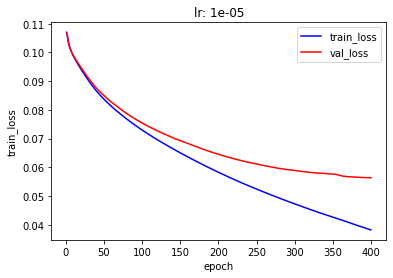

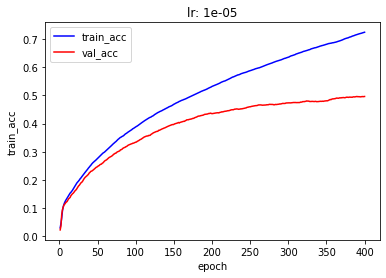

In [18]:

# plot tuning results
import seaborn as sns

sns.lineplot(data=history, x='epoch', y='train_loss', label='train_loss', color="blue")
sns.lineplot(data=history, x='epoch', y='val_loss', label='val_loss', color="red")
plt.legend()
plt.title("lr: " + str(Params['lr']))
plt.show()

sns.lineplot(data=history, x='epoch', y='train_acc', label='train_acc', color="blue")
sns.lineplot(data=history, x='epoch', y='val_acc', label='val_acc', color="red")
plt.legend()
plt.title("lr: " + str(Params['lr']))
plt.show()


In [ ]:

# hyperparameter tuning

lr_list = [0.0001, 0.00005, 0.00001]

all_history_df = pd.DataFrame()
best_model_stats = {}

for i,lr in enumerate(lr_list):

    Params = {'datasize':256, 'in_channels':3, 'num_classes':45, 
              'dataset_pct':1, # use smaller pct for faster testing
              'batch_size':512, 'num_epochs':2, 'lr':lr, 
              'verbose':True, 'output_int':1, 'save_model':False}

    try:
      del model
    except:
      pass

    model = Conv_Pred()
    model.weight_init()
    model.to(device)

    bce_loss = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr = Params['lr'])

    print("\n grid search iteration {} of {} | num_epochs: {:d} | learning_rate: {:1.8f}\n".
          format(i+1, len(lr_list), Params['num_epochs'], lr))
     
    # train model and return performance over epochs
    history, best_model_stats = train_model(model, train_loader, val_loader, 
                                            optimizer, bce_loss, Params, best_model_stats)

    history['lr'] = lr
    history['num_epochs'] = Params['num_epochs']
         
    all_history_df = all_history_df.append(pd.DataFrame(history))
    all_history_df.reset_index(drop=True, inplace=True)

    best_idx = all_history_df['val_loss'].argmin()
    print("\n best current model:  lr: {:1.7f} | epoch: {:d} | val_loss: {:1.3f} | val_acc: {:1.3f}\n".format(
        all_history_df.loc[best_idx, 'lr'], 
        all_history_df.loc[best_idx, 'epoch'], 
        all_history_df.loc[best_idx, 'val_loss'], 
        all_history_df.loc[best_idx, 'val_acc']))
  


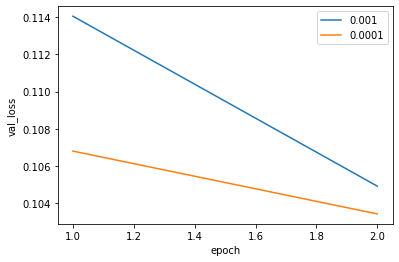

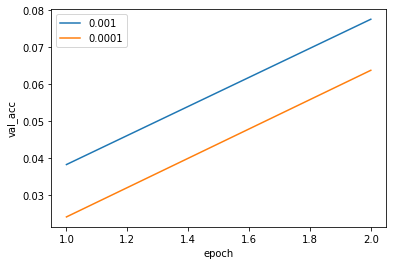

In [101]:
# plot grid search results

sns.lineplot(data=all_history_df, x='epoch', y='val_loss', hue=all_history_df['lr'].astype('str'))
plt.legend()
plt.show()

sns.lineplot(data=all_history_df, x='epoch', y='val_acc', hue=all_history_df['lr'].astype('str'))
plt.legend()
plt.show()

